<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [2]:
# Importing neccesary packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import scipy
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


from scipy.stats import randint as sp_randint

In [3]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# TFIDF on question 1 & 2

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts


tfidf= TfidfVectorizer(lowercase=False, )
word2tfidf_q1=tfidf.fit_transform(df['question1'])
word2tfidf_q2=tfidf.fit_transform(df['question2'])



In [6]:
from scipy.sparse import hstack
word2tfidf = hstack((word2tfidf_q1,word2tfidf_q2))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

# NLP features 

In [7]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [8]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [9]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [10]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [11]:
# since both the data is sparse matrix to we need to convert the dataframe to sparse before combining them
df_1_sparse = scipy.sparse.csr_matrix(df1)

In [12]:
data = hstack((df_1_sparse, word2tfidf))

# Train test split

In [13]:
y_true = df['is_duplicate']

In [14]:
y_true = list(map(int, y_true.values))

In [15]:
X_train_data,X_test_data, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
standardized_data_train = scaler.fit_transform(X_train_data)
standardized_data_test = scaler.transform(X_test_data)

print("train data shape",standardized_data_train.shape)
print("Test data shape ",standardized_data_test.shape)

train data shape (283003, 163085)
Test data shape  (121287, 163085)


In [17]:
X_train = standardized_data_train
X_test = standardized_data_test

# ML_Models On TFIDF

In [18]:
# utility functions
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Random base Model

Log loss on Test Data using Random Model 0.8875780697924233


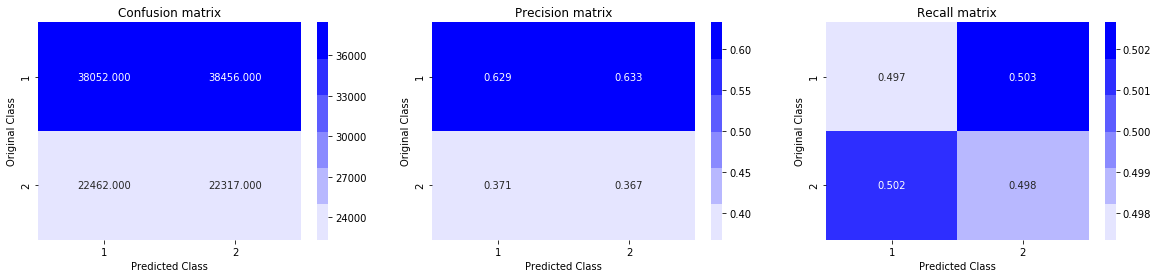

In [26]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.12682931842744324
For values of alpha =  0.0001 The log loss is: 0.12460524502183357
For values of alpha =  0.001 The log loss is: 0.12577814436564633
For values of alpha =  0.01 The log loss is: 0.0875826650255526
For values of alpha =  0.1 The log loss is: 0.04802418587822497
For values of alpha =  1 The log loss is: 0.19664547425030052
For values of alpha =  10 The log loss is: 0.290732715753861


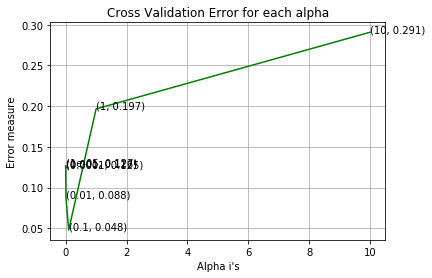

For values of best alpha =  0.1 The train log loss is: 0.01648526781241877
For values of best alpha =  0.1 The test log loss is: 0.04802418587822497
Total number of data points : 121287


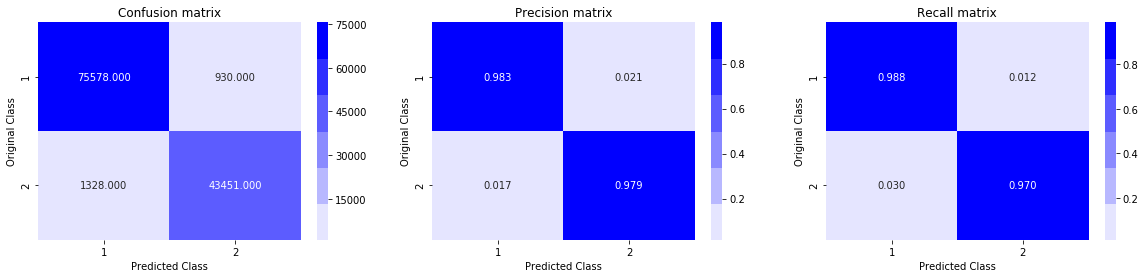

In [27]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=1,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=1,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM 

For values of alpha =  1e-05 The log loss is: 0.18158802288829054
For values of alpha =  0.0001 The log loss is: 0.30004159184373347
For values of alpha =  0.001 The log loss is: 0.4648421441151048
For values of alpha =  0.01 The log loss is: 0.602827787231203
For values of alpha =  0.1 The log loss is: 0.6564654362262332
For values of alpha =  1 The log loss is: 0.6584717934861789
For values of alpha =  10 The log loss is: 0.6585211262162713


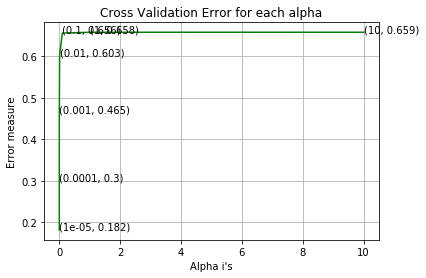

For values of best alpha =  1e-05 The train log loss is: 0.142611483026068
For values of best alpha =  1e-05 The test log loss is: 0.18158802288829054
Total number of data points : 121287


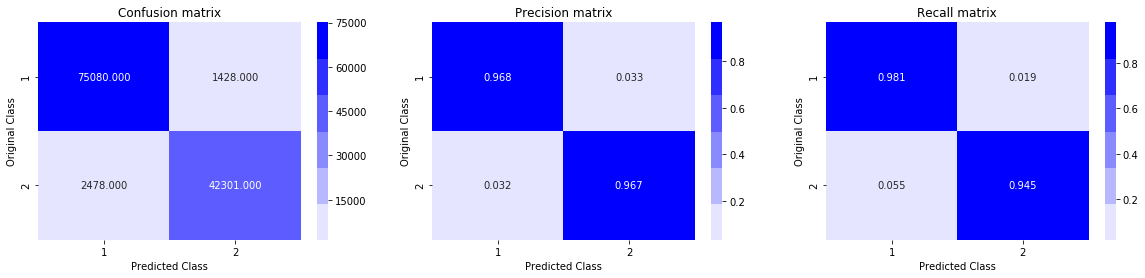

In [28]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=1,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=1,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBOOST with Hyper parameter tuning

In [19]:
params = {
        'max_depth': sp_randint(1,11),
        'n_estimators' : sp_randint(5,100),
        }

model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
xgb_model = RandomizedSearchCV(model, param_distributions = params,n_iter=50, scoring = 'neg_log_loss', n_jobs = -1,cv=3)
xgb_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027F0928DF28>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027F0928D780>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [20]:
print("Model Score = ",xgb_model.best_score_)
print("Best Params = ",xgb_model.best_params_)

Model Score =  -3.2899413024384785e-05
Best Params =  {'max_depth': 3, 'n_estimators': 99}


In [21]:
optimal_depth = 3
optimal_estimators = 99

In [22]:
clf = xgb.XGBClassifier(max_depth=optimal_depth,objective='binary:logistic',n_estimators=optimal_estimators,n_jobs=-1)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=99, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Log loss [Train] :  2.2846215806084714e-05
Log loss [Test] :  2.28462011937605e-05


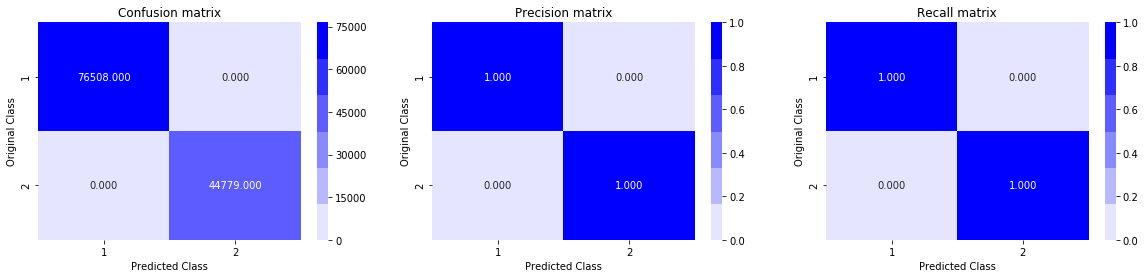

In [23]:
#log loss uses a exact probability score so we have to extract the score from the model
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)
predict_y = cal_clf.predict_proba(X_train)

print("Log loss [Train] : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)
print("Log loss [Test] : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Comparision BTW TFTDF W2V and Simple TFIDF model

In [29]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model(TF-IDF w2v)", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression", 0.528 ,0.534])
x.add_row(["Linear SVM", 0.481 ,0.489])
x.add_row(["XGBoost(not tuned)", 0.346, 0.357])
print(x)

x = PrettyTable()
x.field_names = ["Model(TF-IDF)", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression", 0.016 , 0.048])
x.add_row(["Linear SVM", 0.142 , 0.181])
x.add_row(["XGBoost(tuned)",  '2.28e**-5' , '2.28e**-5'])
print(x)

+---------------------+----------------+---------------+
|  Model(TF-IDF w2v)  | Train log loss | Test log loss |
+---------------------+----------------+---------------+
| Logistic Regression |     0.528      |     0.534     |
|      Linear SVM     |     0.481      |     0.489     |
|  XGBoost(not tuned) |     0.346      |     0.357     |
+---------------------+----------------+---------------+
+---------------------+----------------+---------------+
|    Model(TF-IDF)    | Train log loss | Test log loss |
+---------------------+----------------+---------------+
| Logistic Regression |     0.016      |     0.048     |
|      Linear SVM     |     0.142      |     0.181     |
|    XGBoost(tuned)   |   2.28e**-5    |   2.28e**-5   |
+---------------------+----------------+---------------+
